# Incorporating transaction cost to mimic 'real-life' portfolio

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("Ken_French_Data.csv", header=0, index_col=0, na_values=-99.99)

rets = data/100
rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')

#Paper uses excess return, therefore need to take risk-free rate off industry returns
d1 = rets
d1 = d1.drop(['Mkt-RF','RF'], 1)
d1 = d1.sub(rets['RF'], axis =0)
d1["Mkt-RF"] = rets["Mkt-RF"]

rets = d1

# Function Preparation

In [2]:
#Paper uses mean and std for expected return and volatility calculation
def monthly_rets(r):
    return r.mean()

def monthly_vol(r):
    return r.std()

def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol (weights, cov):
    return (weights.T @ cov @ weights)**0.5

#Risk free rate set to 0 as the data is already excess returns
def sharpe_ratio(r):
    sharpe = r.mean()/r.std()
    return sharpe

def weight_ew(r):
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    return ew

def mv_func(mean, cov):
    num_assets = cov.shape[0]
    inv_cov = np.linalg.pinv(cov)
    wtgs = (inv_cov@mean)/(np.ones((1,num_assets))@inv_cov@mean)
    return wtgs

def min_v_func(cov):
    num_assets = cov.shape[0]
    er = [1] * num_assets
    inv_cov = np.linalg.pinv(cov)
    wtgs = (inv_cov@er)/(np.ones((1,num_assets))@inv_cov@er)
    return wtgs

def ceq(r):
    gamma = 1
    return r.mean() - ((gamma/2) * r.var())

In [3]:
#Transaction costs function (only applies to 'commission-based', doesnt have fix fees)

def TC_fn_IS(TC, wtgs, rets):
    TC_df = []
    for Dates, t in rets.iterrows():
        #Getting difference in weightings
        diff = wtgs - (wtgs * rets.loc[Dates] * wtgs)
        #Calculates transaction costs only for closing/adjustment positions
        t = abs(diff*TC).sum()
        TC_df.append(t)
    TC_df =pd.DataFrame(TC_df, index = rets.index, columns =['Transaction_Costs'])
    return TC_df

def TC_fn_OoS(TC, wtgs, rets):
    TC_df = []
    for Dates, t in rets.iterrows():
        #Getting difference in weightings
        diff = wtgs.loc[Dates] - (wtgs.loc[Dates] * rets.loc[Dates] * wtgs.loc[Dates])
        #Calculates transaction costs only for closing/adjustment positions
        t = abs(diff*TC).sum()
        TC_df.append(t)
    TC_df =pd.DataFrame(TC_df, index = rets.index, columns =['Transaction_Costs'])
    return TC_df

# Portfolio construction

In [4]:
#Using 10 basis points as the transaction costs to closing positions
#Could implement 'normal-noises' as a real-life experiment if appropraite
TC= 0.001

#Equal-Weighted (1/N) Portfolio
PortRet= []  
for Date,ew in rets.iterrows():
    ew = weight_ew(rets).values    
    PortRet.append(ew@rets.loc[Date].values)
#Returns of portfolio (before transaction costs)
EW_Result = pd.DataFrame(PortRet, index = rets.index, columns =['Portfolio_return'])

#Calculating transaction costs
EW_tc = TC_fn_IS(TC = TC, wtgs = ew, rets = rets)
#Returns of portfolio (after transaction costs)
EW_Result_a = EW_Result['Portfolio_return'] - EW_tc['Transaction_Costs']

In [5]:
#In-sample Mean-Variance (MV-IS) Portfolio
f_mean = monthly_rets(rets)
f_cov = rets.cov()
#Generating weights
mv_wtgs_IS = mv_func(f_mean, f_cov)
#Multiplying weights with industries return
IS_MV = rets.mul(mv_wtgs_IS, axis=1).sum(axis=1)
#Returns of portfolio (before transaction costs)
IS_MV =pd.DataFrame(IS_MV, index = rets.index, columns =['Portfolio_return'])

#Calculating transaction costs
IS_MV_tc = TC_fn_IS(TC = TC, wtgs = mv_wtgs_IS, rets = rets)
#Returns of portfolio (after transaction costs)
IS_MV_a = IS_MV['Portfolio_return'] - IS_MV_tc['Transaction_Costs']

In [6]:
RW = 120

#Out-of-sample Mean-Variance (MV-OoS) portfolio
#Rolling window for mean and variance
RW_mean = rets.rolling(RW, min_periods= RW).mean().dropna()
RW_cov = rets.rolling(RW, min_periods= RW).cov().dropna()
#Shifting date to match analysis dates as it is t-1
RW_mean = RW_mean.loc["1973-07":"2004-11"]
RW_cov = RW_cov.loc["1973-07": "2004-11"]
#Developing backtest system in a rolling window basis
OoS_MV = []
for Dates, w in RW_cov.groupby(level = "Date"):
    mean = RW_mean.loc[Dates]
    cov = RW_cov.loc[Dates,:].values
    w = mv_func(mean, cov)
    OoS_MV.append(w)
#Weights
OoS_MV = pd.DataFrame(OoS_MV, index= rets[RW:].index, columns = list(RW_mean))    
OoS_MV_rets = []
for Date, w in rets[RW:].iterrows():
    w = OoS_MV.loc[Date].values  
    OoS_MV_rets.append(w@rets.loc[Date].values)
#Returns of portfolio (before transaction costs)
OoS_MV_rets =pd.DataFrame(OoS_MV_rets, index = rets[RW:].index, columns =['Portfolio_return'])

#Calculating transaction costs
RW_rets = rets.loc["1973-07":"2004-11"]
OoS_MV_tc = TC_fn_OoS(TC = TC, wtgs = OoS_MV, rets = RW_rets)
#Returns of portfolio (after transaction costs)
OoS_MV_a = OoS_MV_rets['Portfolio_return'] - OoS_MV_tc['Transaction_Costs']

In [7]:
#Out-of-sample Minimum-Variance (Min-OoS) Portfolio
#Developing backtest system in a rolling window basis
OoS_MinV = []
for Dates, w in RW_cov.groupby(level = "Date"):
    cov = RW_cov.loc[Dates,:].values
    w = min_v_func(cov)
    OoS_MinV.append(w)
#Weights
OoS_MinV = pd.DataFrame(OoS_MinV, index= rets[RW:].index, columns = list(RW_mean))    
OoS_MinV_rets = []
for Date, w in rets[RW:].iterrows():
    w = OoS_MinV.loc[Date].values  
    OoS_MinV_rets.append(w@rets.loc[Date].values) 
#Returns of portfolio (before transaction costs)
OoS_MinV_rets =pd.DataFrame(OoS_MinV_rets, index = rets[RW:].index, columns =['Portfolio_return'])

#Calculating transaction costs
RW_rets = rets.loc["1973-07":"2004-11"]
OoS_MinV_tc = TC_fn_OoS(TC = TC, wtgs = OoS_MinV, rets = RW_rets)
#Returns of portfolio (after transaction costs)
OoS_MinV_a = OoS_MinV_rets['Portfolio_return'] - OoS_MinV_tc['Transaction_Costs']

In [8]:
import warnings
warnings.filterwarnings('ignore')

btr = pd.DataFrame({"1/N ": EW_Result_a,
                    "MV (IS)": IS_MV_a,
                    "MV (OoS)": OoS_MV_a,
                    "Min (OoS)": OoS_MinV_a
                   })
%run 'Summary_stats.ipynb'
summary_stats(btr)

,Annualized Return,Annualized Vol,Sharpe Ratio,Skewness,Kurtosis,Max Drawdown
1/N,0.041320,0.145948,0.101493,-0.425117,5.008328,-0.559675
MV (IS),-0.025446,0.190713,-0.011444,0.153536,5.174522,-0.841934
MV (OoS),NaN,2613.570507,-0.052835,-19.333318,374.851451,-14648.744674
Min (OoS),-0.004155,0.109640,0.001348,0.020456,3.412436,-0.416126


In [9]:
btr.describe()

,1/N,MV (IS),MV (OoS),Min (OoS)
count,497.000000,497.000000,377.000000,377.000000
mean,0.004276,-0.000630,-39.862780,0.000043
std,0.042131,0.055054,754.472818,0.031650
min,-0.219593,-0.240829,-14648.744674,-0.105695
25%,-0.019684,-0.035797,-0.132651,-0.021224
50%,0.006055,-0.003250,-0.032684,0.000787
75%,0.032239,0.034648,0.012272,0.019631
max,0.150486,0.256157,0.595134,0.098875


<AxesSubplot:title={'center':'Cumulative wealth from $100'}, xlabel='Date'>

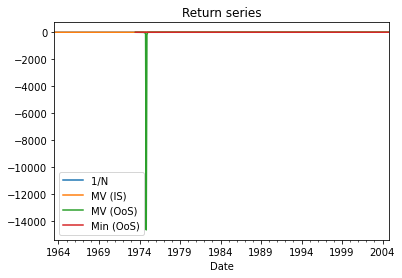

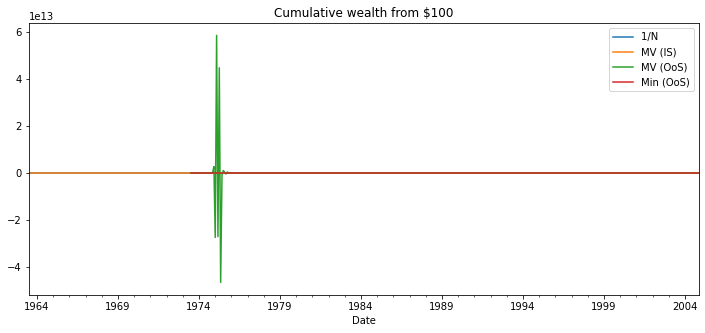

In [10]:
#Return Series of portfolios
btr.plot(title='Return series')

#Cumulative wealth by investing $100
(100*(1+btr).cumprod()).plot(figsize=(12,5), title = 'Cumulative wealth from $100')

#Seems like OoS-MV portfolio is the anomaly

<AxesSubplot:title={'center':'Cumulative wealth from $100'}, xlabel='Date'>

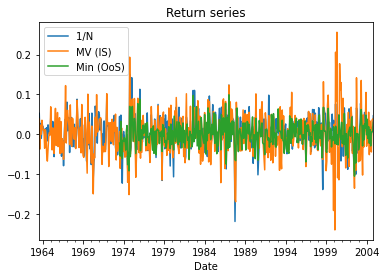

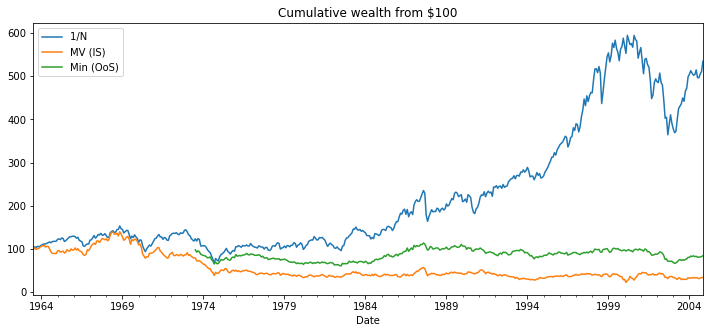

In [11]:
#Trying to remove MV (OoS) in order to remove outliers.
btr = btr.drop(['MV (OoS)'], 1)

#Return Series of portfolios
btr.plot(title='Return series')

#Cumulative wealth by investing $100
(100*(1+btr).cumprod()).plot(figsize=(12,5), title = 'Cumulative wealth from $100')